In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Reshape, TimeDistributed
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
K.tensorflow_backend._get_available_gpus()
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [3]:
data = pd.read_csv('smooth_industry.csv')
# fin = pd.read_csv('data/smooth_finance.csv')
data.head()

,date,close_Transportation,smooth_Transportation,close_Finance,smooth_Finance,close_Manufactoring,smooth_Manufactoring,close_Wholesale,smooth_Wholesale,close_Services,smooth_Services,close_Public,smooth_Public,close_Construction,smooth_Construction,close_Retail,smooth_Retail,close_Mining,smooth_Mining
0,2010-01-05,22.823604,22.800803,65.830455,65.764691,20.195778,20.175603,19.462535,19.443092,18.636101,18.617484,14.008396,13.994401,27.807690,27.779911,21.030696,21.009687,21.387686,21.366320
1,2010-01-06,22.877452,22.839299,66.142888,65.954637,20.277470,20.226764,19.574467,19.509074,18.604432,18.610929,14.292948,14.144343,27.964614,27.872676,21.118698,21.064437,21.711506,21.539686
2,2010-01-07,22.882703,22.854001,66.229848,66.047859,20.362396,20.272707,19.811392,19.611478,18.591263,18.604267,13.936618,14.073981,28.629108,28.128902,21.232373,21.121322,21.642212,21.574415
3,2010-01-08,22.921272,22.871395,66.612488,66.193850,20.446907,20.317748,19.611474,19.611477,18.840240,18.665281,14.219720,14.111663,29.115584,28.384020,21.331934,21.175778,21.888843,21.655714
4,2010-01-11,23.016817,22.902181,66.669747,66.294600,20.511654,20.358799,19.685278,19.627101,18.733277,18.679676,14.257421,14.142521,28.236922,28.352878,21.561473,21.257431,21.744483,21.674507


In [4]:
industry = ['_Finance', '_Construction', '_Transportation', '_Manufactoring', '_Wholesale',
            '_Services', '_Public', '_Retail', '_Mining']

for i in industry:
    data['return'+i] = np.append(1, np.array(data.loc[1:,'smooth'+i])/np.array(data.iloc[:-1]['smooth'+i]))-1

In [5]:
def get_X(data, time_step, industry, target_col = 'return', do_sc = True, test_size = 0.2):
    train, test = train_test_split(data, test_size = test_size, shuffle = False)
    sc = MinMaxScaler()
    industry = [target_col + '_' + i for i in industry]
    print(industry)
    if do_sc:
        train[industry] = sc.fit_transform(train[industry])
        test[industry] = sc.transform(test[industry])
    
    X = []
    for i in range(len(train)-time_step+1):
        for ind in industry:
            X.append(train.iloc[i:i+time_step][ind])
    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    X_train = X[:-len(industry)]
    y_train = X[len(industry):]
    
    X = []
    for i in range(len(test)-time_step+1):
        for ind in industry:
            X.append(test.iloc[i:i+time_step][ind])
    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    X_test = X[:-len(industry)]
    y_test = X[len(industry):]
    
    return X_train, y_train, X_test, y_test, train, test, sc

In [6]:
industry = ['Finance']
time_step = 60

X_train, y_train, X_test, y_test, train, test, sc = get_X(data, time_step, industry, 'return')

['return_Finance']


/Users/rongliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/rongliu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/rongliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [14]:
X_train.shape

(1750, 60, 1)

In [7]:
def build_vae(batch_size, time_step, input_dim, latent_dim, start_node):
    inp = Input(shape = (time_step, input_dim))
    
    enc = LSTM(start_node*2, return_sequences=True)(inp)
    enc = LSTM(start_node)(enc)
    
    z_mean = Dense(latent_dim)(enc)
    z_log_sigma = Dense(latent_dim)(enc)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        batch = K.shape(z_mean)[0]
        epsilon = K.random_normal(shape = (batch, latent_dim))
        return z_mean + K.exp(z_log_sigma)*epsilon
    
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    dec_inp = Input(shape = (latent_dim,))
    dec = RepeatVector(time_step)(dec_inp)
    dec = LSTM(start_node, return_sequences=True)(dec)
    dec = LSTM(start_node*2, return_sequences=True)(dec)
    #dec_out = LSTM(input_dim, activation=None, return_sequences=True)(dec)
    dec_out = TimeDistributed(Dense(1))(dec)
    #dec_out = Reshape((K.shape(dec_out)[0], K.shape(dec_out)[1]))(dec_out)
    
    encoder = Model(inp, z)
    decoder = Model(dec_inp, dec_out)
    
    vae_out = decoder(encoder(inp))
    vae = Model(inp, vae_out)
    
    #kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
    kl_loss = K.mean(-0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1))
    vae.add_loss(kl_loss)
    opt = Adam(lr = 0.0002)
    vae.compile(loss = 'binary_crossentropy', optimizer = opt)
    
    return encoder, decoder, vae

In [8]:
def build_vae_dense(batch_size, time_step, input_dim, latent_dim, start_node):
    inp = Input(shape = (time_step, ))
    
    #enc = LSTM(start_node*2, return_sequences=True)(inp)
    #enc = LSTM(start_node)(enc)
    enc = Dense(start_node*2, activation='relu')(inp)
    enc = Dense(start_node, activation='relu')(enc)
    
    z_mean = Dense(latent_dim)(enc)
    z_log_sigma = Dense(latent_dim)(enc)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        batch = K.shape(z_mean)[0]
        epsilon = K.random_normal(shape = (batch, latent_dim))
        return z_mean + K.exp(z_log_sigma)*epsilon
    
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    dec_inp = Input(shape = (latent_dim,))

    dec = Dense(start_node, activation='relu')(dec_inp)
    dec = Dense(start_node*2, activation='relu')(dec)
    dec_out = Dense(time_step, activation=None)(dec)
    
    encoder = Model(inp, z)
    decoder = Model(dec_inp, dec_out)
    
    vae_out = decoder(encoder(inp))
    vae = Model(inp, vae_out)
    
    #kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
    kl_loss = K.mean(-0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1))
    vae.add_loss(kl_loss)
    opt = Adam(lr = 0.0002)
    vae.compile(loss = 'categorical_crossentropy', optimizer = opt)
    
    return encoder, decoder, vae

In [10]:
batch_size = 32
input_dim = 1
latent_dim = 16
start_node = 256

encoder, decoder, vae = build_vae(batch_size, 60, input_dim, latent_dim, start_node)

In [13]:
vae.fit(X_train, y_train, epochs=20, batch_size = batch_size, verbose = 0)

In [14]:
pred = vae.predict(X_test)
predy = sc.inverse_transform(pred[:,-1].reshape(-1,1))
testy = sc.inverse_transform(y_test[:,-1].reshape(-1,1))

0.0993092893043487


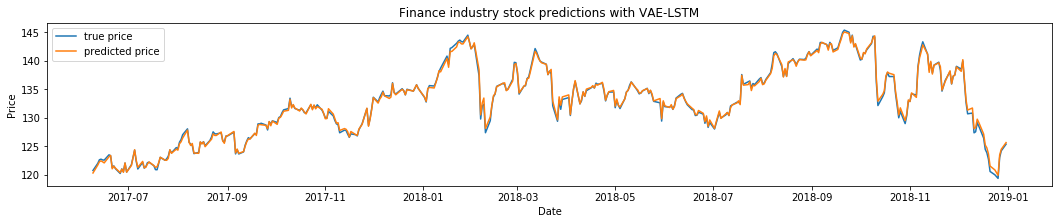

In [18]:
plt.rcParams['figure.figsize'] = (18,3)
test.date = pd.to_datetime(test.date)
ind = 'Finance'
#ind = 'Construction'
col = 0
a1 = np.array(test.iloc[59:-1]['close_'+ind])*(testy[:,col]+1)
a2 = np.array(test.iloc[59:-1]['close_'+ind])*(predy[:,col]+1)
#plt.plot(range(len(predy)), a3, linewidth = 1, label = 'true')
plt.plot_date(test.iloc[60:]['date'], a1, '-', label = 'true price')
plt.plot_date(test.iloc[60:]['date'], a2, '-', label = 'predicted price')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Finance industry stock predictions with VAE-LSTM');
print(np.mean((a1-a2)**2))

In [51]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 1)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 60, 512)      1052672     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256)          787456      lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           4112        lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_2 (D

In [70]:
inter_model1 = Model(vae1.input, [encoder1.get_layer("dense_4").output, encoder1.get_layer("dense_5").output])
#z_mean, z_log_sigma = inter_model.predict(X_train)

In [55]:
from sklearn.decomposition import PCA

z_mean_pca = PCA(n_components=2).fit_transform(z_mean)
z_log_sigma_pca = PCA(n_components=2).fit_transform(z_log_sigma)

In [79]:
state = np.loadtxt('data/2010-2016hiddenstates_5states.txt')

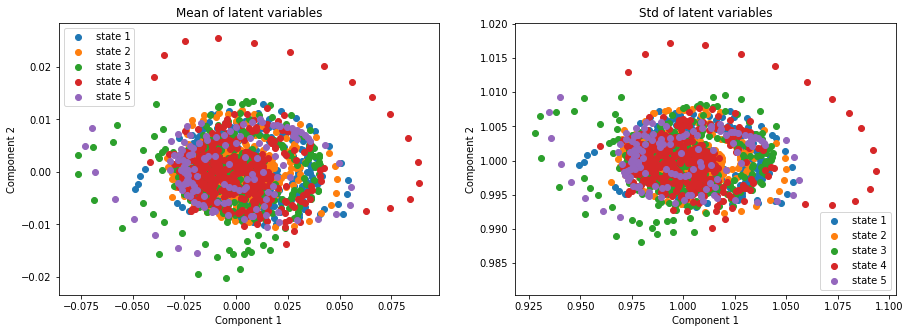

In [330]:
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(1,2,1)
for i in range(5):
    #plt.scatter(z_mean_pca[::2,0], z_mean_pca[::2,1])
    plt.scatter(z_mean_pca[state[:1750] == i,0], z_mean_pca[state[:1750]==i, 1], label = 'state '+str(i+1))
#plt.scatter(z_mean_pca[1::2,0], z_mean_pca[1::2,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Mean of latent variables')
plt.legend()

plt.subplot(1,2,2)
for i in range(5):
    tmp = np.exp(z_log_sigma_pca)
    plt.scatter(tmp[state[:1750]==i, 0], tmp[state[:1750]==i, 1], label = 'state '+str(i+1))
plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Std of latent variables');


Text(0.5, 1.0, 'Top component of mean and std of the latent variables')

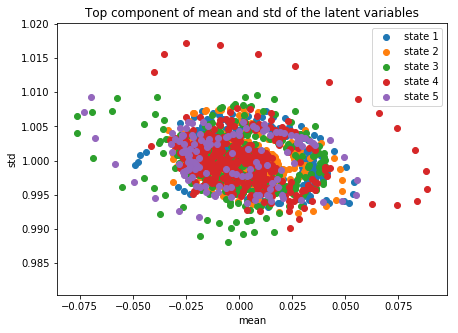

In [329]:
plt.rcParams['figure.figsize'] = (7,5)
tmp1 = z_mean_pca
tmp2 = np.exp(z_log_sigma_pca)
for i in range(5):
    plt.scatter(tmp1[state[:1750] == i, 0], tmp2[state[:1750] == i, 1], label = 'state '+str(i+1))
plt.legend()
plt.xlabel('mean')
plt.ylabel('std')
plt.title('Top component of mean and std of the latent variables')